
[colab code](https://colab.research.google.com/github/PytorchLightning/pytorch-lightning/blob/master/notebooks/03-basic-gan.ipynb#scrollTo=DOY_nHu328g7)

In [1]:
import os
from argparse import ArgumentParser
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import pytorch_lightning as pl

In [2]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, data_dir: str = './', batch_size: int = 64, num_workers: int = 8):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (1, 28, 28)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [4]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [19]:
class GAN(pl.LightningModule):

    def __init__(
        self,
        channels,
        width,
        height,
        latent_dim: int = 100,
        lr: float = 0.0002,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = 64,
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        data_shape = (channels, width, height)
        self.generator = Generator(latent_dim=self.hparams.latent_dim, img_shape=data_shape)
        self.discriminator = Discriminator(img_shape=data_shape)

        self.validation_z = torch.randn(8, self.hparams.latent_dim)

        self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(imgs)
        # train generator
        if optimizer_idx == 0:

            # generate images
            self.generated_imgs = self(z)

            # log sampled images
            sample_imgs = self.generated_imgs[:6]
            grid = torchvision.utils.make_grid(sample_imgs)
            self.logger.experiment.add_image('generated_images', grid, 0)

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)
            tqdm_dict = {'g_loss': g_loss}
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

            # how well can it label as fake?
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)

            fake_loss = self.adversarial_loss(
                self.discriminator(self(z).detach()), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            tqdm_dict = {'d_loss': d_loss}
            output = OrderedDict({
                'loss': d_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)

        # log sampled images
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

In [20]:
dm = MNISTDataModule()
model = GAN(*dm.size())
trainer = pl.Trainer(gpus=0, max_epochs=5, progress_bar_refresh_rate=20)
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/opt/conda/envs/test/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)

  | Name          | Type          | Params | In sizes | Out sizes     
----------------------------------------------------------------------------
0 | generator     | Generator     | 1.5 M  | [2, 100] | [2, 1, 28, 28]
1 | discriminator | Discriminator | 533 K  | ?        | ?             
----------------------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.174     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

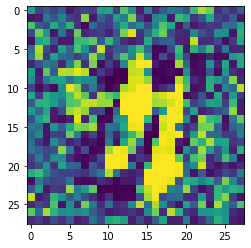

In [21]:
import matplotlib.pyplot as plt
model.eval()
z = torch.randn(1, model.hparams.latent_dim)
plt.imshow(model(z).detach().numpy()[0,0,:])